<a href="https://colab.research.google.com/github/egorssed/2D_Heat_Equation_Simulation/blob/master/Neural_Networks/Gaussian_process_inference/Regressor/Colab_VGG_LDE_Runtime_10_years.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun Aug 14 08:15:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
import os, sys
from google.colab import drive
# Change to mount '/content/drive/My Drive/Fermilab/'
drive.mount('/content/drive')
Folder='/content/drive/MyDrive/Fermilab/'

#!pip install scipy==1.7.1 --quiet
#!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.11.0+cu113.html --quiet



import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
mpl.style.use('default')

import torch
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

Modulesfolder = Folder

import sys
sys.path.append(Modulesfolder)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50'

FS = 18 # fontsize

min_years = 10
max_years = 10

!pip install einops --quiet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

## RDRW Dataset class

In [16]:
from torch.utils.data import Dataset
import numpy as np
from Modules.Gaussian_process import RDRW
from Modules.datasets.Reverberating_Damped_Random_Walk import Masking
from Modules.datasets.Reverberating_Damped_Random_Walk.Utils import Normalise
from scipy.interpolate import BSpline
import time
eps = 1e-8 # softening

import torch.multiprocessing as multiprocessing
multiprocessing.set_start_method('spawn')

import jax
import jax.numpy as jnp

def jax_RDRW_cov(abs_time_difference, Correlation_time, Reverberation_time):
  Normalisation = 1. / (Correlation_time  - Reverberation_time)
  Time_dependence = Correlation_time * jnp.exp(-abs_time_difference / Correlation_time) - \
                Reverberation_time * jnp.exp(-abs_time_difference / Reverberation_time)

  return Normalisation*Time_dependence


def jax_RDRW_Cholesky(time_array,Correlation_time,Reverberation_time):
  time_difference = time_array[None,:] - time_array[:,None]
  Correlation_matrix = jax_RDRW_cov(jnp.abs(time_difference),Correlation_time,Reverberation_time)  + jnp.eye(len(time_array)) * eps
  L = jax.scipy.linalg.cholesky(Correlation_matrix, lower=True,check_finite=False)
  return L 

jax_RDRW_cov = jax.jit(jax_RDRW_cov,backend='gpu')
jax_RDRW_Cholesky = jax.jit(jax_RDRW_Cholesky,backend='gpu')


def get_truncnorm_sampler(mean,std,lower_limit,upper_limit,rng):
    normalised_limits = (lower_limit - mean) / std , (upper_limit - mean) / std

    def sampler(size):
        return stats.truncnorm.rvs(*normalised_limits, size=size, loc=mean, scale=std,random_state=rng)

    return sampler

def Poisson_process_subsampling_mask(process_rate, desired_rate, shape, rng = None):
    """
    Theorem 1.4 (Partitioning a Poisson process)
    If $\psi \sim PP(\lambda)$ and if each arrival of $\psi$ is, independently, type 1 or type 2
    with probability $p$ and $q = 1 − p$ then in fact, letting $\psi_i$ denote the point process
    of type $i$ arrivals, $i = 1, 2$, $ψ_1 \sim PP(p\lambda)), ψ_2 \sim PP(q\lambda))$ and they are independent.
    @inproceedings{Sigman20061I6,
    title={1 IEOR 6711 : Notes on the Poisson Process},author={Karl Sigman},year={2006}
    }
    """
    assert desired_rate<=process_rate

    if rng is None:
        rng = np.random.default_rng(seed=42)

    subsampling_probability = desired_rate/process_rate

    mask = rng.binomial(1,subsampling_probability,size=shape).astype(bool)

    return mask

class RDRW_simulator():

    def __init__(self,Poisson_scale = 5, Saturation_offset = None,time_random_seed = 7,magnitude_random_seed=42):

        self.Poisson_scale = Poisson_scale
        if Saturation_offset is None:
            Saturation_offset = 2

        self.Saturation_offset = Saturation_offset

        self.rng_time = np.random.default_rng(time_random_seed)
        self.rng_mag = np.random.default_rng(magnitude_random_seed)

    def sample_time(self,duration):

        # Elementary Renewal theorem for Poisson process
        size = round(duration*365 / self.Poisson_scale)

        cadences = self.rng_time.exponential(size=size,scale=self.Poisson_scale)
        time_array=np.append([0],np.cumsum(cadences))

        return time_array


    def RDRW_Cholesky(self,time_array,Correlation_time,Reverberation_time):

      time_difference = time_array[None,:] - time_array[:,None]

      Correlation_matrix = jax_RDRW_cov(np.abs(time_difference),Correlation_time,Reverberation_time)  + np.eye(len(time_array)) * eps

      L = scipy.linalg.cholesky(Correlation_matrix, lower=True,check_finite=False)

      return L 

    def __call__(self,Correlation_time,Reverberation_time,duration = 1):


        #start_t = time.time()
        time_array = self.sample_time(duration+self.Saturation_offset)
        #end_t = time.time()
        #print('Time sampling:',end_t-start_t)

        #start_t = time.time()
        
        Cholesky = np.asarray(jax_RDRW_Cholesky(time_array, Correlation_time,Reverberation_time))
        #end_t = time.time()
        #print('Cholesky decomposition:',end_t-start_t)

        #start_t = time.time()
        magnitude_noise=self.rng_mag.normal(size=len(time_array))
        #end_t = time.time()
        #print('Realisation sampling:',end_t-start_t)

        #start_t = time.time()
        magnitude = Cholesky @ magnitude_noise
        #end_t = time.time()
        #print('Matrix multiplication:',end_t-start_t)

        #start_t = time.time()
        saturation_start = np.argmin((time_array[-1] - time_array - 365*duration)>0) -2
        #end_t = time.time()
        #print('Search for start:',end_t-start_t)

        normalised_time = (time_array[saturation_start:]-time_array[saturation_start+1]) / 365

        return normalised_time,magnitude[saturation_start:]


class Observations_RDRW(Dataset):

    def __init__(self, labels: np.ndarray,Poisson_scale = 5,
                 min_years=1,
                 max_years=10,
                 border_gap_params=(72, 25), border_gap_bounds=(0, np.inf),
                 light_curve_norm=(1, -1), Saturation_offset = None,
                 time_random_seed = 7,magnitude_random_seed=42,
                 gaps_random_seed = 18,years_random_seed = 32,subsampling_random_seed=48):

        super().__init__()

        self.labels = labels
        self.RDRW_simulator = RDRW_simulator(Poisson_scale,Saturation_offset,time_random_seed,magnitude_random_seed)

        self.rng_gaps = np.random.default_rng(gaps_random_seed)
        self.border_params = np.array([*border_gap_params, *border_gap_bounds]) / 365

        #self.border_gap_sampler = sampler
        #self.border_gap_sampler = get_truncnorm_sampler(*border_params, self.rng_gaps)

        self.normalise_class = Normalise(*light_curve_norm)

        self.min_years = min_years
        self.max_years = max_years
        self.rng_years = np.random.default_rng(years_random_seed)

        self.rng_subsampling = np.random.default_rng(subsampling_random_seed)

    def subsampling_mask(self,shape,Poisson_scale = 5):
        return Poisson_process_subsampling_mask(1/self.RDRW_simulator.Poisson_scale,1/Poisson_scale,shape,self.rng_subsampling)


    def get_no_gaps_masks(self,time_array,num_observed_years):

        gaps = self.rng_gaps.normal(loc = self.border_params[0],scale = self.border_params[1],size=2 * num_observed_years).reshape(2, num_observed_years)
        gaps *= (gaps>0)

        #gaps = self.border_gap_sampler(2 * num_observed_years).reshape(2, num_observed_years)
        gaps[0] += (np.arange(num_observed_years))
        gaps[1] = (np.arange(1, 1 + num_observed_years)) - gaps[1]
        gaps_mask = ((time_array[None, :] > gaps[0, :, None]) & (time_array[None, :] < gaps[1, :, None])).sum(0).astype(
            bool)

        return gaps_mask

    def normalise_magnitudes(self,observed,complete = None,labels = None):

        value_bounds = (np.max(observed), np.min(observed))
        value_normalisation = self.normalise_class.light_curve_normalisation(*value_bounds)

        normalised_observed =  self.normalise_class.normalise_light_curve(observed, *value_normalisation)

        if complete is None:
            normalised_complete = None
        else:
            normalised_complete = self.normalise_class.normalise_light_curve(complete, *value_normalisation)

        if labels is None:
            normalised_labels = None
        else:
            normalised_labels = self.normalise_class.normalise_label(labels, *value_normalisation,
                                                                     time_factor=1.)

        return normalised_observed,normalised_complete,normalised_labels

    def __len__(self):
      return len(self.labels)

    def get_item(self,label_index):

        labels = self.labels[label_index]

        start_t = time.time()
        num_observed_years = self.rng_years.integers(low=self.min_years,
                                                     high=self.max_years+1)
        
        end_t = time.time()
        #print('Num years sampling:',end_t-start_t)
        

        start_t = time.time()
        time_array,magnitude_array = self.RDRW_simulator(*labels,duration=num_observed_years)
        end_t = time.time()
        #print('RDRW simulator:',end_t-start_t)

        start_t = time.time()
        no_gaps_mask = self.get_no_gaps_masks(time_array,num_observed_years)
        end_t = time.time()
        #print('Gaps masks:',end_t-start_t)

        obs_time_array = time_array[no_gaps_mask]
        obs_magnitude_array = magnitude_array[no_gaps_mask]

        complete_labels = np.array([0, 1, *labels])
        obs_magnitude_array,magnitude_array,normalised_labels = self.normalise_magnitudes(obs_magnitude_array,magnitude_array,complete_labels)

        log_labels = np.array([normalised_labels[0], *np.log10(normalised_labels[1:])])

        return obs_time_array,obs_magnitude_array,time_array,magnitude_array,log_labels,num_observed_years

class Spline_Observations_RDRW(Observations_RDRW):

  def __init__(self, *args,**kwargs):

    super().__init__(*args,**kwargs)


    num_ref_points = 365
    step = 1 / num_ref_points
    self.query = np.linspace(step/2, 1 - step/2, num_ref_points,dtype=np.float32)
    self.full_query = np.repeat([self.query],self.max_years,axis=0) + np.arange(self.max_years)[:,None]

  def interpolate(self,time,light,padding='zeros'):

      spline_degree = 1
      spliner = BSpline(np.pad(time,(spline_degree,spline_degree),'edge'),
                         np.pad(light,(0,spline_degree+1),'edge'), spline_degree, extrapolate=False)
      spline = spliner(self.full_query)
      
      mask_left = self.full_query < time[0]
      mask_right =  self.full_query > time[-1]
      spline_masks = ~np.logical_or(mask_left,mask_right)
      # edge padding
      if padding=='edge':
          spline[mask_left] = light[0]
          spline[mask_right] = light[-1]
      elif padding=='zeros':
          spline[mask_left] = 0.
          spline[mask_right] = 0.
      else:
          raise  ValueError("Paddding should be either 'zeros' or 'edge")
      return spline,spline_masks

  def get_item(self,label_index):

    labels = self.labels[label_index]

    num_observed_years = self.rng_years.integers(low=self.min_years,
                                                 high=self.max_years+1)

    time_array,magnitude_array = self.RDRW_simulator(*labels,duration=num_observed_years)

    no_gaps_mask = self.get_no_gaps_masks(time_array,num_observed_years)

    obs_time_array = time_array[no_gaps_mask]
    obs_magnitude_array = magnitude_array[no_gaps_mask]

    complete_labels = np.array([0, 1, *labels])
    obs_magnitude_array,_,normalised_labels = self.normalise_magnitudes(obs_magnitude_array,None,complete_labels)

    log_labels = np.array([normalised_labels[0], *np.log10(normalised_labels[1:])])

    context_splines,_ = self.interpolate(obs_time_array,obs_magnitude_array)

    return context_splines,log_labels

  def __getitem__(self, index):
      item = self.get_item(index)
      return (*item,index)

  def _to_tensor(self, array,device = None):
      if device is None:
        device = self.device
      return torch.from_numpy(np.stack(array)).type(torch.float32).to(device)

  def collate_fn(self, batch):
      # meant to be redefined in subclasses for training purposes
      # this is an example of full use of functionality

      context_splines,labels,  idx = np.stack(batch, axis=1)

      #return [self._to_tensor(x) for x in [context_splines,out_labels,num_observed_years]]
      return [self._to_tensor(x,'cpu') for x in [context_splines,labels]]

In [17]:
dataset = Observations_RDRW(np.array([[400,30]]),Poisson_scale=5,min_years=5)

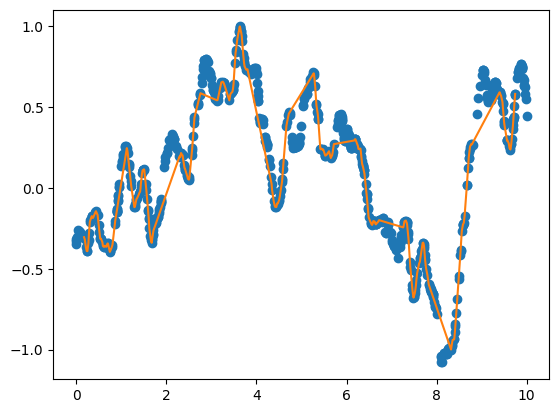

In [18]:
obs_time_array,obs_magnitude_array,time_array,magnitude_array,log_labels,num_observed_years = dataset.get_item(0)

plt.scatter(time_array,magnitude_array)
plt.plot(obs_time_array,obs_magnitude_array,color='C1')

## Simulate labels

In [19]:
from scipy import stats
def get_truncnorm_sampler(mean,std,lower_limit,upper_limit,rng):
    normalised_limits = (lower_limit - mean) / std , (upper_limit - mean) / std

    def sampler(size):
        return stats.truncnorm.rvs(*normalised_limits, size=size, loc=mean, scale=std,random_state=rng)

    return sampler

mu_logcorr = 2.6
std_logcorr = 0.4

log_corr_bounds=(1.8,3.4)

mu_logrev = 1.25
std_logrev = 0.28

log_rev_bounds=(0.6,1.8)
logcorr_rng = np.random.default_rng(78)
logrev_rng = np.random.default_rng(18)

log_corr_sampler=get_truncnorm_sampler(mu_logcorr,std_logcorr,*log_corr_bounds,logcorr_rng)
log_rev_sampler=get_truncnorm_sampler(mu_logrev,std_logrev,*log_rev_bounds,logrev_rng)

In [20]:
num_labels = 100000
log_rev_samples = log_rev_sampler(size=num_labels)
log_corr_samples = log_corr_sampler(size=num_labels)

labels_data = np.power(10, np.array([log_corr_samples, log_rev_samples])).T

## Compile dataset

In [21]:
from sklearn.model_selection import train_test_split
train_labels,val_labels = train_test_split(labels_data,test_size=0.2,random_state=42)
test_labels,val_labels = train_test_split(val_labels,test_size=0.5,random_state=24)
print(np.array([len(train_labels),len(val_labels),len(test_labels)])/num_labels)

[0.8 0.1 0.1]


In [22]:
from torch.utils.data import DataLoader
batch_size = 128
num_workers=0

def get_dataloader(labels):
  _ = jax_RDRW_Cholesky(np.arange(365),400,30)
  dataset = Spline_Observations_RDRW(labels,Poisson_scale=5,min_years=min_years,max_years=max_years)

  dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=False,
    drop_last=True, collate_fn=dataset.collate_fn,pin_memory=True,num_workers = num_workers)
  
  return dataloader

In [23]:
train_loader = get_dataloader(train_labels)
val_loader = get_dataloader(val_labels)
test_loader = get_dataloader(test_labels)

In [24]:
context_splines,out_labels = next(iter(test_loader))
context_splines = context_splines.to(device)
out_labels = out_labels.to(device)

## Prepare for training

In [25]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    sum_grads = []
    layers = []
    ave_grad_dict={}
    sum_grad_dict = {}
    fig,ax = plt.subplots(1,2,figsize=(15,7))
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            if (p.grad is None) or ((p.grad==0).all()):
                continue
            layers.append(n)
            grads = p.grad
            ave_grads.append(np.log10(grads[grads!=0].abs().mean().item()))
            sum_grads.append(np.log10(grads[grads!=0].abs().sum().item()))
            ave_grad_dict[n] = ave_grads[-1]
            sum_grad_dict[n] = sum_grads[-1]

    ax[0].plot(ave_grads, alpha=0.3, color="b")
    ax[0].hlines(np.mean(ave_grads), 0, len(ave_grads)+1, linewidth=1, color="k" )
    ax[0].set_ylabel("Log average abs gradient")

    ax[1].plot(sum_grads, alpha=0.3, color="b")
    ax[1].hlines(np.mean(sum_grads), 0, len(ave_grads)+1, linewidth=1, color="k" )
    ax[1].set_ylabel("Log sum abs gradient")

    for i in range(2):
        ax[i].set_xticks(range(0,len(ave_grads), 1))
        ax[i].set_xticklabels(layers, rotation=90)
        ax[i].set_xlim(xmin=0, xmax=len(ave_grads))
        ax[i].set_xlabel("Layers")

    fig.suptitle("Gradient flow")
    plt.grid(True)
    #fig.patch.set_alpha(0)

    return ave_grad_dict,sum_grad_dict

# Baseline

## Architecture


In [26]:
from Modules.Neural_Networks.Continuous_Convolutional_NNs.CConv_NN_modules.Continuous_convolution import build_Bspline
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def conv_bn_relu(in_dim, out_dim,width_stride=2):
    return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, (3,3), (1,width_stride), 1,bias=False),
        nn.BatchNorm2d(out_dim),
        nn.ReLU())

def dconv_bn_relu(in_dim, out_dim,width_stride=2,output_w_padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, (3,3), (1,width_stride),
                           padding=1, output_padding=(0,output_w_padding), bias=False),
        nn.BatchNorm2d(out_dim),
        nn.ReLU())

def L_out_conv(L_in,width_stride=2):
    return (L_in+2*1-1*(3-1)-1)//width_stride+1

def L_out_dconv(L_in,width_stride=2):
    return (L_in-1)*width_stride-2*1+1*(3-1)+1


num_ref_points = 365
# Size after encoder's convolutional layers
size_change = lambda f,x: f(f(f(f(x))))
conv_size=size_change(L_out_conv,num_ref_points)

In [27]:
from copy import deepcopy
import time
import einops
from typing import Union

class LDE(nn.Module):
    """
    Learnable dictionary encoding layer

    Layer accumulate statistics on more detailed units. It combines
    the dictionary learning and vector encoding steps into a single
    layer for end-to-end learning. It used for speaker embedding creation.

    Parameters
    ----------
    num_clusters : int
        Number of learnable clusters. (defines `C` in papers)
    input_dim : int
        Second dimension of input tensor. The frequency/bands dimension
        of spectrogram squeezed by a encoder model.
    bias : bool
        Parameter of using bias for `weights` creation. default `False`.
        (Is in the original implementation)
    trainable_weights : bool
        Parameter determines the use of additional
        trainable weights for `weights` creation. default `False`.
    pooling : 'mean' or 'mean+std'
        Parameter determines what the returned tensor consists of.
        It change size of last dimension of returned tensor!

    References
    ----------
     - Original implementation:
       https://github.com/jefflai108/pytorch-kaldi-neural-speaker-embeddings/blob/master/scripts/model.py#L334;
     - Introduction of LDE for speaker recognition: https://arxiv.org/abs/1804.05160;
     - LDE for creation speaker embedding for TTS purpose: https://arxiv.org/abs/1910.10838.
    """
    def __init__(self, num_clusters: int, input_dim: int,
                 bias: bool = False, trainable_weights: bool = False,
                 smoothing_factor: float=1., pooling: Union['mean', 'mean+std'] = 'mean+std'):
        super(LDE,self).__init__()


        self.dict = nn.Parameter(torch.randn(num_clusters, input_dim))
        torch.nn.init.normal_(self.dict.data, mean=0.0, std=1.0)
        if trainable_weights:
            self.w = nn.Parameter(torch.ones(num_clusters))
        else:
            self.register_buffer('w', torch.ones(num_clusters) * smoothing_factor)
        self.bias = nn.Parameter(torch.zeros(num_clusters)) if bias else 0
        self.pool = pooling

        # it could be x**2 for 'sqr' instead of 'norm'
        self.distance = lambda x: torch.norm(x, p=2, dim=-1)

        #self.norm = lambda x: F.softmax(-self.distance(x) * (self.w ** 2) + self.bias, dim = -1)

    def norm(self,x,ignore_mask = None):

      weighted_distance = -self.distance(x) * (self.w ** 2) + self.bias

      if ignore_mask is not None:
        weighted_distance.masked_fill_(ignore_mask.view((*weighted_distance.shape[:-1],1)),-1e9)

      return F.softmax(weighted_distance,dim=-1)


    def forward(self, x, ignore_mask = None):
        """
        x: [Batch, Timesteps, 1, Freq]
        mask: [Batch,Freq]

        """

        x = x.unsqueeze(-2)                                                     # [Batch, Timesteps, 1, Freq]
        residual_tensor = (x - self.dict)                                # [Batch, Timesteps, num_clusters, Freq]

        weights = self.norm(residual_tensor,ignore_mask)                        # [Batch, Timesteps, num_clusters]
        weights = weights.unsqueeze(-1)                                         # [Batch, Timesteps, num_clusters, 1]
        weights = weights / (torch.sum(weights, dim=1, keepdim=True) + 1e-9)

        means = torch.sum(weights * residual_tensor, dim=1)    # [Batch, num_clusters, Freq]
        if self.pool == 'mean+std':
            stds = torch.sqrt(torch.sum(weights * residual_tensor ** 2, dim=1) + 1e-9)
            means_and_stds = torch.cat([means, stds], dim=-1)
            return means_and_stds.view(x.size(0), -1)                           # [Batch, 2 * num_clusters * Freq]

        return means
        #return means.view(x.size(0), -1)                                        # [Batch, num_clusters * Freq]

class Encoder(nn.Module):
    def __init__(self, seasons_num,reference_points_num, ignore_unseen = False):
        super().__init__()
        self.seasons_num = seasons_num
        self.reference_points_num = reference_points_num
        self.ignore_unseen = ignore_unseen

        # Conv block in ResNet
        self.grid_conv = nn.Sequential(
            conv_bn_relu(1, 64,width_stride=2),
            conv_bn_relu(64, 64,width_stride=2),
            nn.MaxPool2d((1,2),(1,2)),
            conv_bn_relu(64, 128,width_stride=1),
            conv_bn_relu(128, 128,width_stride=1),
            nn.MaxPool2d((1,2),(1,2)),
            conv_bn_relu(128, 256,width_stride=1),
            conv_bn_relu(256, 256,width_stride=1),
            nn.MaxPool2d((1,2),(1,2))
        )

    def forward(self, context_splines):

        #spline_image = context_splines.view(context_splines.shape[0],1,context_splines.shape[1],self.reference_points_num)
        spline_image = context_splines.unsqueeze(1)

        not_observed_mask = (spline_image == 0).all(-1).unsqueeze(-1)
        # grid convolutions

        x = spline_image
        for layer in self.grid_conv:
            x =layer(x)
            if self.ignore_unseen:
              x = torch.mul(x,not_observed_mask)

        return x

class Regressor(nn.Module):

    def __init__(self,encoder,num_clusters=8,output_dim=2,ignore_unseen_lde = False,dropout_rate=0.,intermediate_linear = None):
        super(Regressor,self).__init__()

        self.encoder = encoder
        self.ignore_unseen_lde = ignore_unseen_lde

        transformer_dim = 64
        transformer_heads = 4
        transformer_dim_head = None
        transformer_dim_head = (int(transformer_dim / transformer_heads)) if transformer_dim_head is None else transformer_dim_head
        dropout = 0


        self.project_patches = torch.nn.Linear(256,transformer_dim)
        self.dropout = nn.Dropout(dropout_rate)

        self.lde = LDE(num_clusters,transformer_dim,bias= True,trainable_weights=True,pooling='mean')


        if intermediate_linear is None:
          self.linear = nn.Linear(num_clusters*transformer_dim,output_dim)
          self.intermediate_linear = None
        else:
          self.linear = nn.Linear(num_clusters*transformer_dim,intermediate_linear)
          self.intermediate_linear = nn.Linear(intermediate_linear,output_dim)



    def forward(self,context_splines):

        encoding = self.encoder(context_splines)
        batched_encodings = einops.rearrange(encoding, 'b c (h p1) (w p2)->b (h w p1 p2) c', p1=encoding.shape[-2], p2=encoding.shape[-1])

        patches = self.project_patches(batched_encodings)
        patches = self.dropout(patches)

        if self.ignore_unseen_lde:
          not_observed_mask = (context_splines == 0).all(-1)
          ignore_mask = torch.repeat_interleave(not_observed_mask.unsqueeze(-1),encoding.shape[-1],dim=-1)
          ignore_mask = ignore_mask.flatten(1,2)
        else:
          ignore_mask = None

        y = self.lde(patches,ignore_mask = ignore_mask)
        y =self.dropout(y)
        y = self.linear(y.view(context_splines.shape[0],-1))

        if self.intermediate_linear is not None:
          y = nn.ReLU()(y)
          y = self.intermediate_linear(y)

        return y

## Initialize

In [28]:
encoding = None
batched_encodings = None
patches = None
y = None

encoder = None
regressor = None
optimizer = None

import gc
gc.collect()
torch.cuda.empty_cache()

In [29]:
def _init_weights(m):
    if isinstance(m, torch.nn.Linear):
        #torch.nn.init.kaiming_uniform_(m.weight)
        torch.nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='relu')
        #torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.)
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='relu')
        #torch.nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.)

In [45]:
encoder = Encoder(10,num_ref_points,ignore_unseen = False)
regressor = Regressor(encoder,ignore_unseen_lde = False,num_clusters = 64,dropout_rate=0.1, intermediate_linear = 64).to(device)


_ = encoder.apply(_init_weights)
if regressor.intermediate_linear is None:
  _ = torch.nn.init.xavier_normal_(regressor.linear.weight)
else:
  _ = torch.nn.init.kaiming_normal_(regressor.linear.weight,mode='fan_in',nonlinearity='relu')
  _ = torch.nn.init.xavier_normal_(regressor.intermediate_linear.weight)


_ = torch.nn.init.xavier_uniform_(regressor.lde.dict)
_ = torch.nn.init.xavier_uniform_(regressor.project_patches.weight,0.3)

In [ ]:
"""
log_dir= Folder+'Neural_Networks/VGG_LDE_Regressor/checkpoints_var_input_1_more/conv_64_64_128_128_256_256_proj_64_4_clusters_dopout_0_1/'
model_dict = torch.load(log_dir+'%d_epoch.pth'%15)
regressor.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']

_ = 1
"""

"\nlog_dir= Folder+'Neural_Networks/VGG_LDE_Regressor/checkpoints_var_input_1_more/conv_64_64_128_128_256_256_proj_64_4_clusters_dopout_0_1/'\nmodel_dict = torch.load(log_dir+'%d_epoch.pth'%15)\nregressor.load_state_dict(model_dict['regressor'])\ntrain_loss_history = model_dict['train_loss_history']\nt_cov_history = model_dict['t_cov_history']\nt_rev_history = model_dict['t_rev_history']\nval_loss_history = model_dict['val_loss_history']\nlearning_rate = model_dict['lr']\n\n_ = 1\n"

## Sanity check

In [31]:
import torchsummary
torchsummary.summary(regressor,(10,365))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 10, 183]             576
       BatchNorm2d-2          [-1, 64, 10, 183]             128
              ReLU-3          [-1, 64, 10, 183]               0
            Conv2d-4           [-1, 64, 10, 92]          36,864
       BatchNorm2d-5           [-1, 64, 10, 92]             128
              ReLU-6           [-1, 64, 10, 92]               0
         MaxPool2d-7           [-1, 64, 10, 46]               0
            Conv2d-8          [-1, 128, 10, 46]          73,728
       BatchNorm2d-9          [-1, 128, 10, 46]             256
             ReLU-10          [-1, 128, 10, 46]               0
           Conv2d-11          [-1, 128, 10, 46]         147,456
      BatchNorm2d-12          [-1, 128, 10, 46]             256
             ReLU-13          [-1, 128, 10, 46]               0
        MaxPool2d-14          [-1, 128,

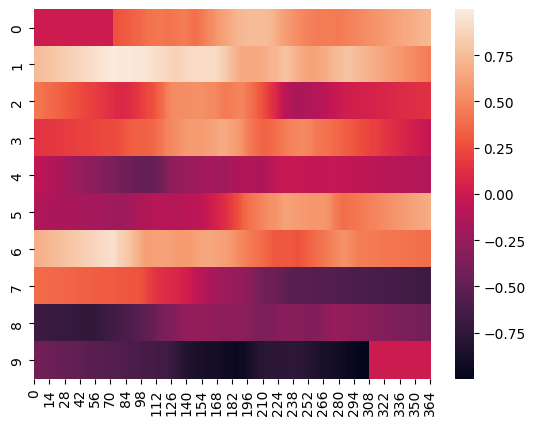

In [32]:
sns.heatmap(context_splines[1].cpu().detach())

In [33]:
y = regressor(context_splines)
y[:10]

tensor([[-0.3404, -0.3764],
        [-0.3779, -0.3103],
        [-0.3902, -0.3857],
        [-0.2781, -0.4379],
        [-0.2636, -0.2430],
        [-0.1985, -0.3960],
        [-0.2936, -0.3027],
        [-0.3081, -0.3632],
        [-0.2805, -0.5084],
        [-0.4936, -0.4454]], device='cuda:0', grad_fn=<SliceBackward0>)

In [34]:
train_theta = torch.tensor(np.log10(train_labels),dtype=torch.float32)
label_mean = train_theta.mean(0).to(device)
label_std = train_theta.std(0).to(device)

In [35]:
def normalize_labels(labels,mean=label_mean,std=label_std):
    norm_labels = labels - mean
    norm_labels /= std
    return norm_labels

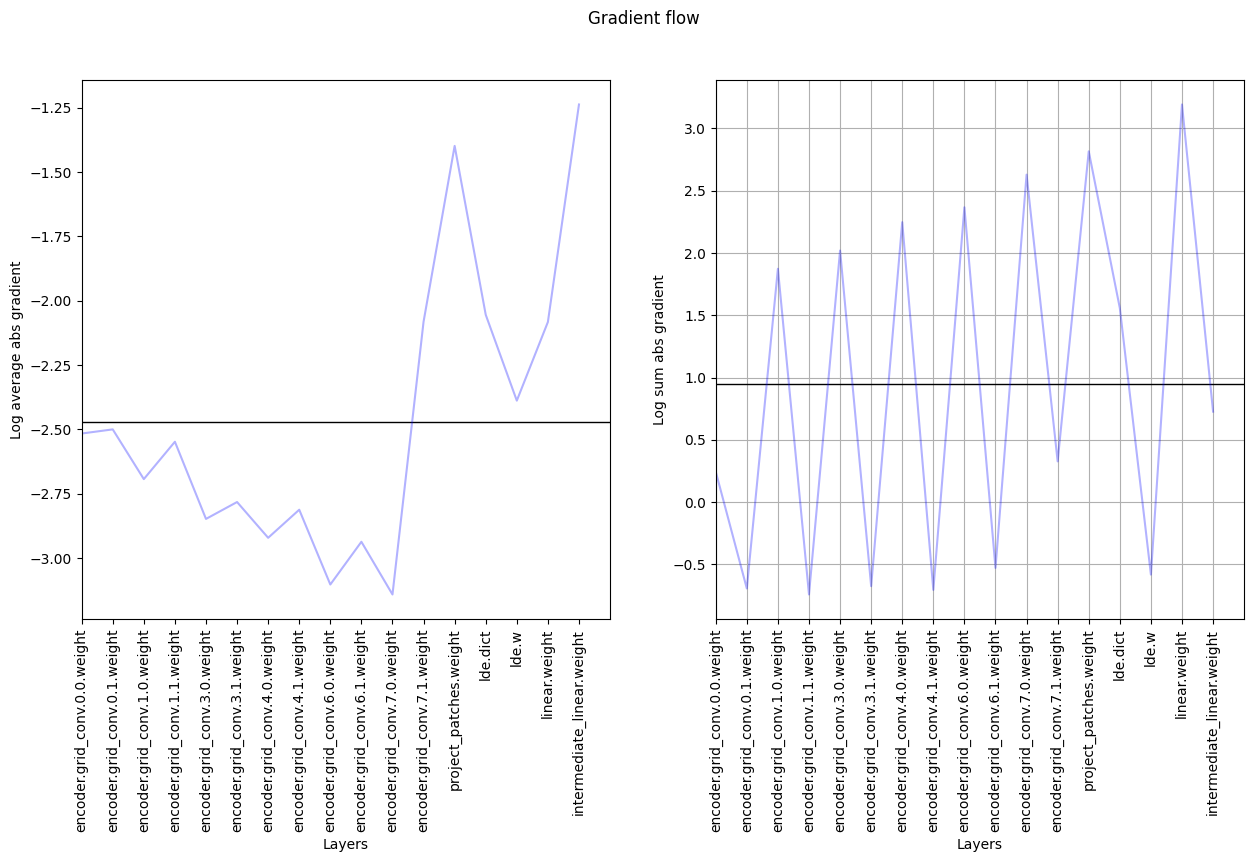

In [36]:
#labels = limit_Corr_t_with_Dur_t(out_labels[:,2:],num_observed_years)
labels = out_labels[:,2:]
true_labels = normalize_labels(labels)
y = regressor(context_splines)
train_loss = torch.mean((y-true_labels)**2)
train_loss.backward()
grad_dict = plot_grad_flow(regressor.named_parameters())

In [37]:
from pathlib import Path
def train_epoch(log_dir,regressor,learning_rate=5e-4,
                train_loss_history = [],val_loss_history = [],
                t_cov_history = [],t_rev_history = [],
                report_iter = 1000,epoch_num=1):
  

  optimizer = torch.optim.Adam(
                list(regressor.parameters()), lr=learning_rate
            )  

  Path(log_dir).mkdir(parents=True, exist_ok=True)

  train_history = []
  train_t_cov_history = []
  train_t_rev_history = []
  regressor.train()

  for i,(context_splines,out_labels) in enumerate(tqdm(train_loader)):


    context_splines = context_splines.to(device)
    out_labels = out_labels.to(device)

    optimizer.zero_grad()

    y = regressor(context_splines)
    #labels = limit_Corr_t_with_Dur_t(out_labels[:,2:],num_observed_years)
    labels = out_labels[:,2:]
    true_labels = normalize_labels(labels)
    #true_labels = normalize_labels(out_labels[:,2:])
    mse = (y-true_labels)**2
    #chi = mse*num_observed_years.unsqueeze(-1)
    loss = torch.mean(mse,dim=0)
    t_cov_loss = loss[0]
    t_rev_loss = loss[1]


    train_loss = torch.mean(loss)

    train_loss.backward()
    optimizer.step()

    train_history.append(train_loss.item())
    train_t_cov_history.append(loss[0].item())
    train_t_rev_history.append(loss[1].item())

    if i%report_iter==(report_iter-1):
        print('Iter {} loss={:.4f} t_cov_loss ={:.4f} t_rev_loss = {:.4f}'.format(i+1,
                        np.mean(train_history[-report_iter:]),np.mean(train_t_cov_history[-report_iter:]),np.mean(train_t_rev_history[-report_iter:])))


  val_history = []
  regressor.eval()

  for i,(context_splines,out_labels) in enumerate(tqdm(val_loader)):

    context_splines = context_splines.to(device)
    out_labels = out_labels.to(device)

    y = regressor(context_splines)
    #true_labels = normalize_labels(out_labels[:,2:])
    #labels = limit_Corr_t_with_Dur_t(out_labels[:,2:],num_observed_years)
    labels = out_labels[:,2:]
    true_labels = normalize_labels(labels)
    mse = (y-true_labels)**2
    #chi = mse*num_observed_years.unsqueeze(-1)
    loss = torch.mean(mse,dim=0)
    val_loss = torch.mean(loss)

    val_history.append(val_loss.item())

  print('Epoch {}, Train loss {:.4f} t_cov {:.4f} t_rev {:.4f}, Val loss {:.4f}'.format(epoch_num,
                      np.mean(train_history),np.mean(train_t_cov_history),np.mean(train_t_rev_history),np.mean(val_history)))
  
  train_loss_history.append(train_history)
  t_cov_history.append(train_t_cov_history)
  t_rev_history.append(train_t_rev_history)
  val_loss_history.append(np.mean(val_history))

  model_dict = {
                'regressor': regressor.state_dict(),
                'epoch': epoch_num,
                'string': regressor.__str__(),
                'train_loss_history': train_loss_history,
                't_cov_history':t_cov_history,
                't_rev_history':t_rev_history,
                'val_loss_history':val_loss_history,
                'lr': learning_rate,
                'label_mean':label_mean.detach().cpu().numpy(),
                'label_std':label_std.detach().cpu().numpy()}

  
  torch.save(model_dict, log_dir + '%d_epoch.pth'%epoch_num)

# Training with stochastic dataset

## 64 LDE clusters, 64 features (like in LDE paper) + intermediate_linear for 64 lr 1e-4 dropout 0.1




In [46]:
log_dir= Folder+'Neural_Networks/VGG_LDE_Regressor/checkpoints_stochastic_10_years/0_0001_lr_conv_64_64_128_128_256_256_proj_64_64_clusters_dopout_0_1_inter_linear_64/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []

In [47]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(0,6):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [02:38<05:29,  1.29it/s]

Iter 200 loss=0.7401 t_cov_loss =0.6297 t_rev_loss = 0.8504


 64%|██████▍   | 400/625 [05:16<02:56,  1.28it/s]

Iter 400 loss=0.6430 t_cov_loss =0.5822 t_rev_loss = 0.7037


 96%|█████████▌| 600/625 [07:53<00:19,  1.28it/s]

Iter 600 loss=0.5889 t_cov_loss =0.5625 t_rev_loss = 0.6154


100%|██████████| 78/78 [00:58<00:00,  1.32it/s]


Epoch 1, Train loss 0.6526 t_cov 0.5890 t_rev 0.7163, Val loss 0.5585


 32%|███▏      | 200/625 [02:38<05:29,  1.29it/s]

Iter 200 loss=0.5319 t_cov_loss =0.5628 t_rev_loss = 0.5010


 64%|██████▍   | 400/625 [05:16<02:56,  1.28it/s]

Iter 400 loss=0.4794 t_cov_loss =0.5388 t_rev_loss = 0.4199


 96%|█████████▌| 600/625 [07:51<00:19,  1.30it/s]

Iter 600 loss=0.4433 t_cov_loss =0.5272 t_rev_loss = 0.3595


100%|██████████| 78/78 [00:59<00:00,  1.32it/s]


Epoch 2, Train loss 0.4823 t_cov 0.5411 t_rev 0.4236, Val loss 0.4161


 32%|███▏      | 200/625 [02:36<06:34,  1.08it/s]

Iter 200 loss=0.4242 t_cov_loss =0.5237 t_rev_loss = 0.3248


 64%|██████▍   | 400/625 [05:12<02:52,  1.30it/s]

Iter 400 loss=0.4064 t_cov_loss =0.5195 t_rev_loss = 0.2934


 96%|█████████▌| 600/625 [07:49<00:19,  1.29it/s]

Iter 600 loss=0.3923 t_cov_loss =0.5077 t_rev_loss = 0.2769


100%|██████████| 78/78 [00:58<00:00,  1.33it/s]


Epoch 3, Train loss 0.4065 t_cov 0.5158 t_rev 0.2972, Val loss 0.3754


 32%|███▏      | 200/625 [02:39<05:31,  1.28it/s]

Iter 200 loss=0.3880 t_cov_loss =0.5104 t_rev_loss = 0.2657


 64%|██████▍   | 400/625 [05:15<02:51,  1.31it/s]

Iter 400 loss=0.3789 t_cov_loss =0.5109 t_rev_loss = 0.2469


 96%|█████████▌| 600/625 [07:53<00:20,  1.24it/s]

Iter 600 loss=0.3682 t_cov_loss =0.4988 t_rev_loss = 0.2376


100%|██████████| 78/78 [00:57<00:00,  1.35it/s]


Epoch 4, Train loss 0.3773 t_cov 0.5057 t_rev 0.2489, Val loss 0.3589


 32%|███▏      | 200/625 [02:39<05:38,  1.25it/s]

Iter 200 loss=0.3661 t_cov_loss =0.5070 t_rev_loss = 0.2252


 64%|██████▍   | 400/625 [05:18<02:53,  1.29it/s]

Iter 400 loss=0.3610 t_cov_loss =0.5038 t_rev_loss = 0.2182


 96%|█████████▌| 600/625 [07:54<00:19,  1.31it/s]

Iter 600 loss=0.3548 t_cov_loss =0.4992 t_rev_loss = 0.2105


100%|██████████| 78/78 [00:58<00:00,  1.34it/s]


Epoch 5, Train loss 0.3600 t_cov 0.5027 t_rev 0.2173, Val loss 0.3698


 32%|███▏      | 200/625 [02:37<05:36,  1.26it/s]

Iter 200 loss=0.3526 t_cov_loss =0.4946 t_rev_loss = 0.2107


 64%|██████▍   | 400/625 [05:12<02:55,  1.28it/s]

Iter 400 loss=0.3467 t_cov_loss =0.4948 t_rev_loss = 0.1986


 96%|█████████▌| 600/625 [07:48<00:19,  1.28it/s]

Iter 600 loss=0.3457 t_cov_loss =0.4929 t_rev_loss = 0.1984


100%|██████████| 78/78 [00:59<00:00,  1.32it/s]

Epoch 6, Train loss 0.3479 t_cov 0.4937 t_rev 0.2022, Val loss 0.3416


In [48]:
learning_rate = 5e-5

In [49]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(6,10):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [02:36<05:33,  1.27it/s]

Iter 200 loss=0.3416 t_cov_loss =0.4970 t_rev_loss = 0.1863


 64%|██████▍   | 400/625 [05:12<02:52,  1.30it/s]

Iter 400 loss=0.3362 t_cov_loss =0.4874 t_rev_loss = 0.1850


 96%|█████████▌| 600/625 [07:49<00:19,  1.29it/s]

Iter 600 loss=0.3334 t_cov_loss =0.4851 t_rev_loss = 0.1816


100%|██████████| 78/78 [00:56<00:00,  1.37it/s]


Epoch 7, Train loss 0.3367 t_cov 0.4895 t_rev 0.1839, Val loss 0.3237


 32%|███▏      | 200/625 [02:37<05:26,  1.30it/s]

Iter 200 loss=0.3317 t_cov_loss =0.4833 t_rev_loss = 0.1801


 64%|██████▍   | 400/625 [05:14<03:05,  1.21it/s]

Iter 400 loss=0.3311 t_cov_loss =0.4838 t_rev_loss = 0.1783


 96%|█████████▌| 600/625 [07:51<00:19,  1.29it/s]

Iter 600 loss=0.3280 t_cov_loss =0.4809 t_rev_loss = 0.1752


100%|██████████| 78/78 [00:59<00:00,  1.30it/s]


Epoch 8, Train loss 0.3300 t_cov 0.4822 t_rev 0.1777, Val loss 0.3237


 32%|███▏      | 200/625 [02:36<05:58,  1.19it/s]

Iter 200 loss=0.3296 t_cov_loss =0.4829 t_rev_loss = 0.1762


 64%|██████▍   | 400/625 [05:12<02:53,  1.30it/s]

Iter 400 loss=0.3285 t_cov_loss =0.4817 t_rev_loss = 0.1753


 96%|█████████▌| 600/625 [07:50<00:18,  1.32it/s]

Iter 600 loss=0.3239 t_cov_loss =0.4749 t_rev_loss = 0.1729


100%|██████████| 78/78 [00:58<00:00,  1.34it/s]


Epoch 9, Train loss 0.3271 t_cov 0.4792 t_rev 0.1750, Val loss 0.3287


 32%|███▏      | 200/625 [02:36<05:29,  1.29it/s]

Iter 200 loss=0.3231 t_cov_loss =0.4759 t_rev_loss = 0.1703


 64%|██████▍   | 400/625 [05:14<02:58,  1.26it/s]

Iter 400 loss=0.3307 t_cov_loss =0.4924 t_rev_loss = 0.1691


 96%|█████████▌| 600/625 [07:52<00:19,  1.30it/s]

Iter 600 loss=0.3257 t_cov_loss =0.4819 t_rev_loss = 0.1694


100%|██████████| 78/78 [00:57<00:00,  1.35it/s]

Epoch 10, Train loss 0.3260 t_cov 0.4830 t_rev 0.1690, Val loss 0.3453


In [50]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%7)
regressor.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']

In [51]:
learning_rate = 1e-5

In [52]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(7,10):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [02:38<06:03,  1.17it/s]

Iter 200 loss=0.3245 t_cov_loss =0.4766 t_rev_loss = 0.1723


 64%|██████▍   | 400/625 [05:16<02:55,  1.28it/s]

Iter 400 loss=0.3253 t_cov_loss =0.4765 t_rev_loss = 0.1741


 96%|█████████▌| 600/625 [07:53<00:19,  1.31it/s]

Iter 600 loss=0.3253 t_cov_loss =0.4784 t_rev_loss = 0.1722


100%|██████████| 78/78 [00:57<00:00,  1.35it/s]


Epoch 8, Train loss 0.3247 t_cov 0.4765 t_rev 0.1730, Val loss 0.3133


 32%|███▏      | 200/625 [02:36<05:29,  1.29it/s]

Iter 200 loss=0.3252 t_cov_loss =0.4792 t_rev_loss = 0.1713


 64%|██████▍   | 400/625 [05:13<02:59,  1.26it/s]

Iter 400 loss=0.3243 t_cov_loss =0.4750 t_rev_loss = 0.1736


 96%|█████████▌| 600/625 [07:51<00:19,  1.27it/s]

Iter 600 loss=0.3223 t_cov_loss =0.4764 t_rev_loss = 0.1683


100%|██████████| 78/78 [00:59<00:00,  1.32it/s]


Epoch 9, Train loss 0.3238 t_cov 0.4766 t_rev 0.1710, Val loss 0.3133


 32%|███▏      | 200/625 [02:38<05:30,  1.28it/s]

Iter 200 loss=0.3254 t_cov_loss =0.4815 t_rev_loss = 0.1693


 45%|████▌     | 284/625 [03:44<04:29,  1.27it/s]


KeyboardInterrupt: ignored

In [54]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%8)
regressor.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']

In [55]:
learning_rate = 5e-6

In [56]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(8,10):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [02:40<05:28,  1.29it/s]

Iter 200 loss=0.3218 t_cov_loss =0.4758 t_rev_loss = 0.1677


 64%|██████▍   | 400/625 [05:17<02:56,  1.27it/s]

Iter 400 loss=0.3274 t_cov_loss =0.4839 t_rev_loss = 0.1710


 96%|█████████▌| 600/625 [07:54<00:19,  1.28it/s]

Iter 600 loss=0.3204 t_cov_loss =0.4726 t_rev_loss = 0.1682


100%|██████████| 78/78 [00:58<00:00,  1.33it/s]


Epoch 9, Train loss 0.3231 t_cov 0.4774 t_rev 0.1688, Val loss 0.3137


 32%|███▏      | 200/625 [02:36<05:31,  1.28it/s]

Iter 200 loss=0.3279 t_cov_loss =0.4889 t_rev_loss = 0.1669


 64%|██████▍   | 400/625 [05:14<02:52,  1.30it/s]

Iter 400 loss=0.3244 t_cov_loss =0.4802 t_rev_loss = 0.1687


 96%|█████████▌| 600/625 [07:51<00:19,  1.27it/s]

Iter 600 loss=0.3214 t_cov_loss =0.4768 t_rev_loss = 0.1661


100%|██████████| 78/78 [00:58<00:00,  1.34it/s]

Epoch 10, Train loss 0.3243 t_cov 0.4812 t_rev 0.1674, Val loss 0.3106


In [58]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%10)
regressor.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']

In [59]:
Performance_array = np.empty(shape=(0,5))
result = np.zeros((batch_size,5))

for context_splines,out_labels  in tqdm(val_loader):
  
  context_splines = context_splines.to(device)
  y = regressor(context_splines)
  prediction = y * label_std + label_mean
  truth = out_labels[:,2:]

  num_years = (context_splines!=0).any(-1).sum(-1)

  result[:,0] = num_years.cpu().numpy()
  result[:,1:3] = truth.numpy()
  result[:,3:5] = prediction.cpu().detach().numpy()

  Performance_array = np.append(Performance_array,result,axis=0)

100%|██████████| 78/78 [01:05<00:00,  1.19it/s]


In [60]:
import pandas as pd
df = pd.DataFrame(Performance_array,columns=['num years','true tau','true rho','pred tau','pred rho'])

#df.to_csv(log_dir + 'Performance.csv')

In [61]:
learning_rate_history = [1e-4]*6 + [5e-5]*1 + [1e-5]*1 + [5e-6]*2
#np.savez(log_dir+'training_stats.npz',learning_rate_history = learning_rate_history,train_loss_history=np.array(train_loss_history),
#         t_cov_history = np.array(t_cov_history),t_rev_history = np.array(t_rev_history),val_loss_history = np.array(val_loss_history))

In [62]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(10,12):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [02:37<05:24,  1.31it/s]

Iter 200 loss=0.3227 t_cov_loss =0.4794 t_rev_loss = 0.1660


 64%|██████▍   | 400/625 [05:13<02:55,  1.28it/s]

Iter 400 loss=0.3236 t_cov_loss =0.4795 t_rev_loss = 0.1678


 96%|█████████▌| 600/625 [07:53<00:19,  1.29it/s]

Iter 600 loss=0.3194 t_cov_loss =0.4720 t_rev_loss = 0.1668


100%|██████████| 78/78 [00:59<00:00,  1.31it/s]


Epoch 11, Train loss 0.3215 t_cov 0.4763 t_rev 0.1667, Val loss 0.3195


 32%|███▏      | 200/625 [02:36<05:22,  1.32it/s]

Iter 200 loss=0.3212 t_cov_loss =0.4777 t_rev_loss = 0.1646


 64%|██████▍   | 400/625 [05:13<02:55,  1.28it/s]

Iter 400 loss=0.3207 t_cov_loss =0.4739 t_rev_loss = 0.1675


 96%|█████████▌| 600/625 [07:50<00:19,  1.28it/s]

Iter 600 loss=0.3206 t_cov_loss =0.4765 t_rev_loss = 0.1647


100%|██████████| 78/78 [00:59<00:00,  1.31it/s]

Epoch 12, Train loss 0.3203 t_cov 0.4750 t_rev 0.1656, Val loss 0.3066


In [64]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%12)
regressor.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']

In [65]:
learning_rate = 1e-6

In [66]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(12,15):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [02:42<05:31,  1.28it/s]

Iter 200 loss=0.3212 t_cov_loss =0.4758 t_rev_loss = 0.1665


 64%|██████▍   | 400/625 [05:20<02:58,  1.26it/s]

Iter 400 loss=0.3210 t_cov_loss =0.4756 t_rev_loss = 0.1664


 96%|█████████▌| 600/625 [07:59<00:19,  1.27it/s]

Iter 600 loss=0.3204 t_cov_loss =0.4747 t_rev_loss = 0.1661


100%|██████████| 78/78 [00:57<00:00,  1.35it/s]


Epoch 13, Train loss 0.3207 t_cov 0.4752 t_rev 0.1661, Val loss 0.3097


  6%|▌         | 38/625 [00:31<07:59,  1.22it/s]


KeyboardInterrupt: ignored

In [67]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%12)
regressor.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']

In [68]:
Performance_array = np.empty(shape=(0,5))
result = np.zeros((batch_size,5))

for context_splines,out_labels  in tqdm(test_loader):
  
  context_splines = context_splines.to(device)
  y = regressor(context_splines)
  prediction = y * label_std + label_mean
  truth = out_labels[:,2:]

  num_years = (context_splines!=0).any(-1).sum(-1)

  result[:,0] = num_years.cpu().numpy()
  result[:,1:3] = truth.numpy()
  result[:,3:5] = prediction.cpu().detach().numpy()

  Performance_array = np.append(Performance_array,result,axis=0)

100%|██████████| 78/78 [01:07<00:00,  1.15it/s]


In [69]:
import pandas as pd
df = pd.DataFrame(Performance_array,columns=['num years','true tau','true rho','pred tau','pred rho'])

df.to_csv(log_dir + 'Performance.csv')

In [70]:
learning_rate_history = [1e-4]*6 + [5e-5]*1 + [1e-5]*1 + [5e-6]*4
np.savez(log_dir+'training_stats.npz',learning_rate_history = learning_rate_history,train_loss_history=np.array(train_loss_history),
         t_cov_history = np.array(t_cov_history),t_rev_history = np.array(t_rev_history),val_loss_history = np.array(val_loss_history))

## 64 LDE clusters, 64 features (like in LDE paper) + intermediate_linear for 64 lr 1e-4




In [38]:
log_dir= Folder+'Neural_Networks/VGG_LDE_Regressor/checkpoints_stochastic_10_years/0_0001_lr_conv_64_64_128_128_256_256_proj_64_64_clusters_dopout_0_inter_linear_64/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []

In [39]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(0,6):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [02:36<05:24,  1.31it/s]

Iter 200 loss=0.7280 t_cov_loss =0.6332 t_rev_loss = 0.8228


 64%|██████▍   | 400/625 [05:11<02:52,  1.30it/s]

Iter 400 loss=0.6266 t_cov_loss =0.5771 t_rev_loss = 0.6761


 96%|█████████▌| 600/625 [07:45<00:19,  1.30it/s]

Iter 600 loss=0.5647 t_cov_loss =0.5610 t_rev_loss = 0.5684


100%|██████████| 78/78 [00:57<00:00,  1.35it/s]


Epoch 1, Train loss 0.6350 t_cov 0.5882 t_rev 0.6818, Val loss 0.5351


 32%|███▏      | 200/625 [02:34<05:33,  1.27it/s]

Iter 200 loss=0.5037 t_cov_loss =0.5494 t_rev_loss = 0.4579


 64%|██████▍   | 400/625 [05:10<02:52,  1.30it/s]

Iter 400 loss=0.4705 t_cov_loss =0.5460 t_rev_loss = 0.3949


 96%|█████████▌| 600/625 [07:45<00:18,  1.32it/s]

Iter 600 loss=0.4334 t_cov_loss =0.5218 t_rev_loss = 0.3450


100%|██████████| 78/78 [00:58<00:00,  1.32it/s]


Epoch 2, Train loss 0.4666 t_cov 0.5377 t_rev 0.3955, Val loss 0.4162


 32%|███▏      | 200/625 [02:34<05:22,  1.32it/s]

Iter 200 loss=0.4217 t_cov_loss =0.5298 t_rev_loss = 0.3136


 64%|██████▍   | 400/625 [05:09<02:53,  1.29it/s]

Iter 400 loss=0.4022 t_cov_loss =0.5187 t_rev_loss = 0.2857


 96%|█████████▌| 600/625 [07:44<00:19,  1.30it/s]

Iter 600 loss=0.3858 t_cov_loss =0.5087 t_rev_loss = 0.2628


100%|██████████| 78/78 [00:58<00:00,  1.33it/s]


Epoch 3, Train loss 0.4017 t_cov 0.5173 t_rev 0.2862, Val loss 0.4195


 32%|███▏      | 200/625 [02:37<05:30,  1.29it/s]

Iter 200 loss=0.3794 t_cov_loss =0.5086 t_rev_loss = 0.2501


 64%|██████▍   | 400/625 [05:12<03:22,  1.11it/s]

Iter 400 loss=0.3696 t_cov_loss =0.5047 t_rev_loss = 0.2346


 96%|█████████▌| 600/625 [07:46<00:18,  1.32it/s]

Iter 600 loss=0.3574 t_cov_loss =0.4923 t_rev_loss = 0.2225


100%|██████████| 78/78 [00:58<00:00,  1.34it/s]


Epoch 4, Train loss 0.3681 t_cov 0.5014 t_rev 0.2348, Val loss 0.3549


 32%|███▏      | 200/625 [02:35<06:47,  1.04it/s]

Iter 200 loss=0.3621 t_cov_loss =0.5032 t_rev_loss = 0.2209


 64%|██████▍   | 400/625 [05:10<02:51,  1.31it/s]

Iter 400 loss=0.3565 t_cov_loss =0.5046 t_rev_loss = 0.2085


 96%|█████████▌| 600/625 [07:45<00:19,  1.31it/s]

Iter 600 loss=0.3461 t_cov_loss =0.4904 t_rev_loss = 0.2018


100%|██████████| 78/78 [00:57<00:00,  1.36it/s]


Epoch 5, Train loss 0.3542 t_cov 0.4989 t_rev 0.2095, Val loss 0.3378


 32%|███▏      | 200/625 [02:35<05:30,  1.28it/s]

Iter 200 loss=0.3470 t_cov_loss =0.4973 t_rev_loss = 0.1966


 64%|██████▍   | 400/625 [05:10<02:52,  1.31it/s]

Iter 400 loss=0.3401 t_cov_loss =0.4889 t_rev_loss = 0.1913


 96%|█████████▌| 600/625 [07:44<00:19,  1.30it/s]

Iter 600 loss=0.3380 t_cov_loss =0.4906 t_rev_loss = 0.1854


100%|██████████| 78/78 [01:03<00:00,  1.23it/s]

Epoch 6, Train loss 0.3410 t_cov 0.4913 t_rev 0.1907, Val loss 0.3838


In [40]:
learning_rate = 5e-5

In [41]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(6,10):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [02:37<05:27,  1.30it/s]

Iter 200 loss=0.3333 t_cov_loss =0.4890 t_rev_loss = 0.1775


 64%|██████▍   | 400/625 [05:12<02:51,  1.31it/s]

Iter 400 loss=0.3301 t_cov_loss =0.4884 t_rev_loss = 0.1718


 96%|█████████▌| 600/625 [07:47<00:18,  1.32it/s]

Iter 600 loss=0.3251 t_cov_loss =0.4805 t_rev_loss = 0.1696


100%|██████████| 78/78 [00:57<00:00,  1.36it/s]


Epoch 7, Train loss 0.3289 t_cov 0.4852 t_rev 0.1726, Val loss 0.3472


 32%|███▏      | 200/625 [02:36<05:26,  1.30it/s]

Iter 200 loss=0.3250 t_cov_loss =0.4815 t_rev_loss = 0.1686


 64%|██████▍   | 400/625 [05:10<02:53,  1.30it/s]

Iter 400 loss=0.3248 t_cov_loss =0.4828 t_rev_loss = 0.1668


 96%|█████████▌| 600/625 [07:45<00:19,  1.31it/s]

Iter 600 loss=0.3246 t_cov_loss =0.4851 t_rev_loss = 0.1642


100%|██████████| 78/78 [00:58<00:00,  1.34it/s]


Epoch 8, Train loss 0.3239 t_cov 0.4818 t_rev 0.1661, Val loss 0.3178


 32%|███▏      | 200/625 [02:34<05:27,  1.30it/s]

Iter 200 loss=0.3202 t_cov_loss =0.4802 t_rev_loss = 0.1603


 64%|██████▍   | 400/625 [05:07<02:52,  1.31it/s]

Iter 400 loss=0.3222 t_cov_loss =0.4821 t_rev_loss = 0.1623


 96%|█████████▌| 600/625 [07:40<00:21,  1.16it/s]

Iter 600 loss=0.3163 t_cov_loss =0.4753 t_rev_loss = 0.1573


100%|██████████| 78/78 [00:58<00:00,  1.34it/s]


Epoch 9, Train loss 0.3191 t_cov 0.4784 t_rev 0.1598, Val loss 0.3257


 32%|███▏      | 200/625 [02:35<05:22,  1.32it/s]

Iter 200 loss=0.3221 t_cov_loss =0.4858 t_rev_loss = 0.1584


 64%|██████▍   | 400/625 [05:10<02:57,  1.26it/s]

Iter 400 loss=0.3185 t_cov_loss =0.4798 t_rev_loss = 0.1573


 96%|█████████▌| 600/625 [07:44<00:18,  1.33it/s]

Iter 600 loss=0.3179 t_cov_loss =0.4811 t_rev_loss = 0.1547


100%|██████████| 78/78 [00:57<00:00,  1.36it/s]

Epoch 10, Train loss 0.3191 t_cov 0.4817 t_rev 0.1564, Val loss 0.3081


In [42]:
Performance_array = np.empty(shape=(0,5))
result = np.zeros((batch_size,5))

for context_splines,out_labels  in tqdm(val_loader):
  
  context_splines = context_splines.to(device)
  y = regressor(context_splines)
  prediction = y * label_std + label_mean
  truth = out_labels[:,2:]

  num_years = (context_splines!=0).any(-1).sum(-1)

  result[:,0] = num_years.cpu().numpy()
  result[:,1:3] = truth.numpy()
  result[:,3:5] = prediction.cpu().detach().numpy()

  Performance_array = np.append(Performance_array,result,axis=0)

100%|██████████| 78/78 [01:11<00:00,  1.09it/s]


In [43]:
import pandas as pd
df = pd.DataFrame(Performance_array,columns=['num years','true tau','true rho','pred tau','pred rho'])

df.to_csv(log_dir + 'Performance.csv')

In [44]:
learning_rate_history = [1e-4]*6 + [5e-5]*4
np.savez(log_dir+'training_stats.npz',learning_rate_history = learning_rate_history,train_loss_history=np.array(train_loss_history),
         t_cov_history = np.array(t_cov_history),t_rev_history = np.array(t_rev_history),val_loss_history = np.array(val_loss_history))

In [ ]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(6,12):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [02:14<04:31,  1.56it/s]

Iter 200 loss=0.4154 t_cov_loss =0.6006 t_rev_loss = 0.2301


 64%|██████▍   | 400/625 [04:28<02:27,  1.52it/s]

Iter 400 loss=0.4045 t_cov_loss =0.5933 t_rev_loss = 0.2158


 96%|█████████▌| 600/625 [06:40<00:16,  1.54it/s]

Iter 600 loss=0.4057 t_cov_loss =0.5969 t_rev_loss = 0.2146


100%|██████████| 78/78 [00:49<00:00,  1.57it/s]


Epoch 7, Train loss 0.4083 t_cov 0.5968 t_rev 0.2197, Val loss 0.4231


 32%|███▏      | 200/625 [02:12<04:38,  1.53it/s]

Iter 200 loss=0.4036 t_cov_loss =0.5930 t_rev_loss = 0.2141


 64%|██████▍   | 400/625 [04:23<02:27,  1.52it/s]

Iter 400 loss=0.3986 t_cov_loss =0.5885 t_rev_loss = 0.2088


 96%|█████████▌| 600/625 [06:35<00:16,  1.55it/s]

Iter 600 loss=0.3935 t_cov_loss =0.5854 t_rev_loss = 0.2016


100%|██████████| 78/78 [00:48<00:00,  1.59it/s]


Epoch 8, Train loss 0.3977 t_cov 0.5878 t_rev 0.2077, Val loss 0.4026


 32%|███▏      | 200/625 [02:11<04:39,  1.52it/s]

Iter 200 loss=0.4022 t_cov_loss =0.5964 t_rev_loss = 0.2080


 64%|██████▍   | 400/625 [04:22<02:26,  1.54it/s]

Iter 400 loss=0.3989 t_cov_loss =0.5970 t_rev_loss = 0.2007


 96%|█████████▌| 600/625 [06:34<00:16,  1.55it/s]

Iter 600 loss=0.3969 t_cov_loss =0.5949 t_rev_loss = 0.1990


100%|██████████| 78/78 [00:48<00:00,  1.61it/s]


Epoch 9, Train loss 0.3990 t_cov 0.5960 t_rev 0.2020, Val loss 0.4227


  2%|▏         | 13/625 [00:08<06:54,  1.48it/s]


KeyboardInterrupt: ignored

## 64 LDE clusters, 64 features (like in LDE paper) + intermediate_linear for 64




In [ ]:
log_dir= Folder+'Neural_Networks/VGG_LDE_Regressor/checkpoints_stochastic_5_more/conv_64_64_128_128_256_256_proj_64_64_clusters_dopout_0_inter_linear_64/'
learning_rate = 5e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []

In [ ]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(0,6):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [02:15<04:47,  1.48it/s]

Iter 200 loss=0.8435 t_cov_loss =0.7853 t_rev_loss = 0.9017


 64%|██████▍   | 400/625 [04:28<02:27,  1.52it/s]

Iter 400 loss=0.6143 t_cov_loss =0.6824 t_rev_loss = 0.5463


 96%|█████████▌| 600/625 [06:42<00:15,  1.57it/s]

Iter 600 loss=0.4978 t_cov_loss =0.6409 t_rev_loss = 0.3548


100%|██████████| 78/78 [00:50<00:00,  1.56it/s]


Epoch 1, Train loss 0.6442 t_cov 0.6997 t_rev 0.5887, Val loss 0.5135


 32%|███▏      | 200/625 [02:13<04:38,  1.53it/s]

Iter 200 loss=0.4739 t_cov_loss =0.6396 t_rev_loss = 0.3081


 64%|██████▍   | 400/625 [04:25<02:29,  1.50it/s]

Iter 400 loss=0.4546 t_cov_loss =0.6272 t_rev_loss = 0.2819


 96%|█████████▌| 600/625 [06:40<00:16,  1.49it/s]

Iter 600 loss=0.4407 t_cov_loss =0.6199 t_rev_loss = 0.2615


100%|██████████| 78/78 [00:49<00:00,  1.58it/s]


Epoch 2, Train loss 0.4550 t_cov 0.6277 t_rev 0.2824, Val loss 0.4399


 32%|███▏      | 200/625 [02:15<04:41,  1.51it/s]

Iter 200 loss=0.4426 t_cov_loss =0.6285 t_rev_loss = 0.2567


 64%|██████▍   | 400/625 [04:30<02:26,  1.53it/s]

Iter 400 loss=0.4284 t_cov_loss =0.6125 t_rev_loss = 0.2444


 96%|█████████▌| 600/625 [06:43<00:16,  1.50it/s]

Iter 600 loss=0.4212 t_cov_loss =0.6093 t_rev_loss = 0.2330


100%|██████████| 78/78 [00:49<00:00,  1.58it/s]


Epoch 3, Train loss 0.4298 t_cov 0.6157 t_rev 0.2439, Val loss 0.4202


 32%|███▏      | 200/625 [02:15<04:45,  1.49it/s]

Iter 200 loss=0.4173 t_cov_loss =0.6078 t_rev_loss = 0.2268


 64%|██████▍   | 400/625 [04:29<02:29,  1.51it/s]

Iter 400 loss=0.4108 t_cov_loss =0.6044 t_rev_loss = 0.2171


 96%|█████████▌| 600/625 [06:44<00:16,  1.49it/s]

Iter 600 loss=0.4042 t_cov_loss =0.6014 t_rev_loss = 0.2071


100%|██████████| 78/78 [00:50<00:00,  1.54it/s]


Epoch 4, Train loss 0.4100 t_cov 0.6039 t_rev 0.2162, Val loss 0.4266


 32%|███▏      | 200/625 [02:13<04:39,  1.52it/s]

Iter 200 loss=0.4065 t_cov_loss =0.6075 t_rev_loss = 0.2054


 48%|████▊     | 301/625 [03:21<03:36,  1.49it/s]


KeyboardInterrupt: ignored

## 64 LDE clusters, 64 features (like in LDE paper)

In [ ]:
log_dir= Folder+'Neural_Networks/VGG_LDE_Regressor/checkpoints_stochastic_5_more/conv_64_64_128_128_256_256_proj_64_64_clusters_dopout_0_1/'
learning_rate = 5e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []

In [ ]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(0,6):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [02:14<04:37,  1.53it/s]

Iter 200 loss=0.8050 t_cov_loss =0.7534 t_rev_loss = 0.8565


 64%|██████▍   | 400/625 [04:30<02:31,  1.49it/s]

Iter 400 loss=0.5825 t_cov_loss =0.6758 t_rev_loss = 0.4892


 96%|█████████▌| 600/625 [06:44<00:16,  1.51it/s]

Iter 600 loss=0.4883 t_cov_loss =0.6343 t_rev_loss = 0.3424


100%|██████████| 78/78 [00:48<00:00,  1.61it/s]


Epoch 1, Train loss 0.6182 t_cov 0.6847 t_rev 0.5518, Val loss 0.4462


 32%|███▏      | 200/625 [02:15<04:41,  1.51it/s]

Iter 200 loss=0.4717 t_cov_loss =0.6456 t_rev_loss = 0.2977


 64%|██████▍   | 400/625 [04:29<02:30,  1.49it/s]

Iter 400 loss=0.4603 t_cov_loss =0.6340 t_rev_loss = 0.2866


 96%|█████████▌| 600/625 [06:42<00:16,  1.47it/s]

Iter 600 loss=0.4403 t_cov_loss =0.6251 t_rev_loss = 0.2555


100%|██████████| 78/78 [00:48<00:00,  1.62it/s]


Epoch 2, Train loss 0.4559 t_cov 0.6336 t_rev 0.2782, Val loss 0.4275


 32%|███▏      | 200/625 [02:13<04:35,  1.54it/s]

Iter 200 loss=0.4404 t_cov_loss =0.6293 t_rev_loss = 0.2516


 64%|██████▍   | 400/625 [04:25<02:29,  1.51it/s]

Iter 400 loss=0.4329 t_cov_loss =0.6218 t_rev_loss = 0.2439


 96%|█████████▌| 600/625 [06:38<00:16,  1.53it/s]

Iter 600 loss=0.4184 t_cov_loss =0.6067 t_rev_loss = 0.2302


100%|██████████| 78/78 [00:49<00:00,  1.58it/s]


Epoch 3, Train loss 0.4296 t_cov 0.6181 t_rev 0.2412, Val loss 0.4332


 32%|███▏      | 200/625 [02:14<04:37,  1.53it/s]

Iter 200 loss=0.4229 t_cov_loss =0.6210 t_rev_loss = 0.2247


 64%|██████▍   | 400/625 [04:28<02:31,  1.48it/s]

Iter 400 loss=0.4178 t_cov_loss =0.6143 t_rev_loss = 0.2212


 96%|█████████▌| 600/625 [06:40<00:16,  1.54it/s]

Iter 600 loss=0.4041 t_cov_loss =0.6013 t_rev_loss = 0.2069


100%|██████████| 78/78 [00:50<00:00,  1.54it/s]


Epoch 4, Train loss 0.4143 t_cov 0.6115 t_rev 0.2171, Val loss 0.4138


  5%|▌         | 33/625 [00:22<06:51,  1.44it/s]


KeyboardInterrupt: ignored

## 4 LDE clusters, 64 features

In [ ]:
log_dir= Folder+'Neural_Networks/VGG_LDE_Regressor/checkpoints_stochastic_5_more/conv_64_64_128_128_256_256_proj_64_4_clusters_dopout_0_1/'
learning_rate = 5e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []

In [ ]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(0,6):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [03:26<07:10,  1.01s/it]

Iter 200 loss=0.7696 t_cov_loss =0.7313 t_rev_loss = 0.8079


 64%|██████▍   | 400/625 [06:55<03:55,  1.05s/it]

Iter 400 loss=0.5540 t_cov_loss =0.6666 t_rev_loss = 0.4413


 96%|█████████▌| 600/625 [10:21<00:25,  1.01s/it]

Iter 600 loss=0.4789 t_cov_loss =0.6290 t_rev_loss = 0.3287


100%|██████████| 78/78 [01:16<00:00,  1.03it/s]


Epoch 1, Train loss 0.5946 t_cov 0.6731 t_rev 0.5160, Val loss 1.4992


 32%|███▏      | 200/625 [03:23<07:21,  1.04s/it]

Iter 200 loss=0.4627 t_cov_loss =0.6371 t_rev_loss = 0.2883


 64%|██████▍   | 400/625 [06:48<03:50,  1.03s/it]

Iter 400 loss=0.4441 t_cov_loss =0.6238 t_rev_loss = 0.2645


 92%|█████████▏| 572/625 [09:44<00:54,  1.02s/it]


KeyboardInterrupt: ignored

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%1)
regressor.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']

In [ ]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(1,10):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [03:26<07:11,  1.02s/it]

Iter 200 loss=0.4628 t_cov_loss =0.6383 t_rev_loss = 0.2872


 64%|██████▍   | 400/625 [06:51<03:49,  1.02s/it]

Iter 400 loss=0.4454 t_cov_loss =0.6277 t_rev_loss = 0.2631


 96%|█████████▌| 600/625 [10:16<00:25,  1.01s/it]

Iter 600 loss=0.4316 t_cov_loss =0.6146 t_rev_loss = 0.2486


100%|██████████| 78/78 [01:15<00:00,  1.03it/s]


Epoch 2, Train loss 0.4453 t_cov 0.6254 t_rev 0.2651, Val loss 1.5308


  2%|▏         | 13/625 [00:13<10:26,  1.02s/it]


KeyboardInterrupt: ignored

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%2)
regressor.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']

In [ ]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(2,10):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [03:26<07:28,  1.05s/it]

Iter 200 loss=0.4288 t_cov_loss =0.6164 t_rev_loss = 0.2412


 64%|██████▍   | 400/625 [06:48<03:44,  1.00it/s]

Iter 400 loss=0.4191 t_cov_loss =0.6158 t_rev_loss = 0.2224


 96%|█████████▌| 600/625 [10:13<00:25,  1.02s/it]

Iter 600 loss=0.4099 t_cov_loss =0.6047 t_rev_loss = 0.2152


100%|██████████| 78/78 [01:16<00:00,  1.02it/s]


Epoch 3, Train loss 0.4184 t_cov 0.6113 t_rev 0.2254, Val loss 0.4096


 32%|███▏      | 200/625 [03:23<07:14,  1.02s/it]

Iter 200 loss=0.4063 t_cov_loss =0.6007 t_rev_loss = 0.2120


 64%|██████▍   | 400/625 [06:47<03:52,  1.03s/it]

Iter 400 loss=0.4032 t_cov_loss =0.6049 t_rev_loss = 0.2014


 96%|█████████▌| 600/625 [10:13<00:25,  1.03s/it]

Iter 600 loss=0.3961 t_cov_loss =0.5976 t_rev_loss = 0.1946


100%|██████████| 78/78 [01:17<00:00,  1.00it/s]


Epoch 4, Train loss 0.4012 t_cov 0.6001 t_rev 0.2023, Val loss 0.4428


 32%|███▏      | 200/625 [03:26<07:14,  1.02s/it]

Iter 200 loss=0.3939 t_cov_loss =0.5970 t_rev_loss = 0.1909


 64%|██████▍   | 400/625 [06:52<03:47,  1.01s/it]

Iter 400 loss=0.3981 t_cov_loss =0.6068 t_rev_loss = 0.1894


 96%|█████████▌| 600/625 [10:16<00:25,  1.01s/it]

Iter 600 loss=0.3863 t_cov_loss =0.5892 t_rev_loss = 0.1834


100%|██████████| 78/78 [01:16<00:00,  1.02it/s]


Epoch 5, Train loss 0.3924 t_cov 0.5974 t_rev 0.1874, Val loss 0.3901


  7%|▋         | 42/625 [00:43<10:01,  1.03s/it]


KeyboardInterrupt: ignored

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%5)
regressor.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']

In [ ]:
learning_rate = 1e-4

In [ ]:
# jax with 50% of gpu (same with 10% actually)
for epoch in range(5,10):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [03:25<07:13,  1.02s/it]

Iter 200 loss=0.3797 t_cov_loss =0.5880 t_rev_loss = 0.1714


 64%|██████▍   | 400/625 [06:50<03:44,  1.00it/s]

Iter 400 loss=0.3833 t_cov_loss =0.5976 t_rev_loss = 0.1690


 96%|█████████▌| 600/625 [10:13<00:28,  1.13s/it]

Iter 600 loss=0.3765 t_cov_loss =0.5883 t_rev_loss = 0.1647


100%|██████████| 78/78 [01:15<00:00,  1.03it/s]


Epoch 6, Train loss 0.3793 t_cov 0.5906 t_rev 0.1680, Val loss 0.3689


 32%|███▏      | 200/625 [03:24<07:13,  1.02s/it]

Iter 200 loss=0.3723 t_cov_loss =0.5808 t_rev_loss = 0.1637


 64%|██████▍   | 400/625 [06:48<03:52,  1.03s/it]

Iter 400 loss=0.3771 t_cov_loss =0.5887 t_rev_loss = 0.1654


 96%|█████████▌| 600/625 [10:13<00:25,  1.02s/it]

Iter 600 loss=0.3709 t_cov_loss =0.5793 t_rev_loss = 0.1625


100%|██████████| 78/78 [01:14<00:00,  1.05it/s]


Epoch 7, Train loss 0.3733 t_cov 0.5830 t_rev 0.1637, Val loss 0.3681


 32%|███▏      | 200/625 [03:24<07:19,  1.03s/it]

Iter 200 loss=0.3769 t_cov_loss =0.5896 t_rev_loss = 0.1642


 64%|██████▍   | 400/625 [06:50<03:55,  1.05s/it]

Iter 400 loss=0.3744 t_cov_loss =0.5847 t_rev_loss = 0.1641


 96%|█████████▌| 600/625 [10:16<00:24,  1.00it/s]

Iter 600 loss=0.3715 t_cov_loss =0.5810 t_rev_loss = 0.1620


100%|██████████| 78/78 [01:16<00:00,  1.02it/s]


Epoch 8, Train loss 0.3739 t_cov 0.5848 t_rev 0.1631, Val loss 0.3681


 29%|██▉       | 180/625 [03:06<07:40,  1.03s/it]


KeyboardInterrupt: ignored

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%8)
regressor.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']

In [ ]:
learning_rate = 5e-5

In [ ]:
for epoch in range(8,12):
  train_epoch(log_dir,regressor,learning_rate,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [03:27<07:21,  1.04s/it]

Iter 200 loss=0.3759 t_cov_loss =0.5930 t_rev_loss = 0.1589


 64%|██████▍   | 400/625 [06:52<03:54,  1.04s/it]

Iter 400 loss=0.3718 t_cov_loss =0.5843 t_rev_loss = 0.1594


 96%|█████████▌| 600/625 [10:19<00:25,  1.03s/it]

Iter 600 loss=0.3665 t_cov_loss =0.5755 t_rev_loss = 0.1576


100%|██████████| 78/78 [01:14<00:00,  1.04it/s]


Epoch 9, Train loss 0.3716 t_cov 0.5845 t_rev 0.1587, Val loss 0.3641


 32%|███▏      | 200/625 [03:23<07:46,  1.10s/it]

Iter 200 loss=0.3700 t_cov_loss =0.5825 t_rev_loss = 0.1575


 64%|██████▍   | 400/625 [06:50<03:42,  1.01it/s]

Iter 400 loss=0.3674 t_cov_loss =0.5762 t_rev_loss = 0.1585


 96%|█████████▌| 600/625 [10:13<00:25,  1.02s/it]

Iter 600 loss=0.3710 t_cov_loss =0.5818 t_rev_loss = 0.1602


100%|██████████| 78/78 [01:14<00:00,  1.05it/s]


Epoch 10, Train loss 0.3692 t_cov 0.5798 t_rev 0.1587, Val loss 0.3668


  9%|▉         | 58/625 [01:07<10:57,  1.16s/it]


KeyboardInterrupt: ignored

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%10)
regressor.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']

tensor([ 9,  9,  6,  8, 10,  7, 10,  5,  8, 10, 10, 10,  8,  6, 10,  6, 10, 10,
         8,  9,  6,  7,  8,  6,  6,  7,  7,  5, 10,  8,  5,  5,  7,  5,  9,  9,
         9, 10, 10,  6,  9,  6,  5,  6,  9,  9,  9,  6, 10,  9,  6,  5, 10,  8,
        10,  8,  5, 10,  6,  5,  5,  7,  7,  6,  6,  6,  9,  9,  5,  6, 10, 10,
         6,  6,  5,  5,  5,  7,  9,  8,  9,  8,  5,  9,  9,  7,  7,  8, 10, 10,
         9,  6,  5,  7,  8,  8,  9,  5, 10, 10,  7,  7,  6,  5,  8,  7,  6,  8,
        10,  7,  7, 10, 10,  6,  5,  7, 10,  8,  5,  8,  9,  8,  6,  8,  9,  5,
         9,  5], device='cuda:0')

In [ ]:
Performance_array = np.empty(shape=(0,5))
result = np.zeros((batch_size,5))

for context_splines,out_labels  in tqdm(val_loader):
  
  context_splines = context_splines.to(device)
  y = regressor(context_splines)
  prediction = y * label_std + label_mean
  truth = out_labels[:,2:]

  num_years = (context_splines!=0).any(-1).sum(-1)

  result[:,0] = num_years.cpu().numpy()
  result[:,1:3] = truth.numpy()
  result[:,3:5] = prediction.cpu().detach().numpy()

  Performance_array = np.append(Performance_array,result,axis=0)

100%|██████████| 78/78 [01:20<00:00,  1.03s/it]


In [ ]:
import pandas as pd
df = pd.DataFrame(Performance_array,columns=['num years','true tau','true rho','pred tau','pred rho'])

df.to_csv(log_dir + 'Performance.csv')

In [ ]:
learning_rate_history = [5e-4]*5 + [1e-4]*3 + [5e-5]*2
np.savez(log_dir+'training_stats.npz',learning_rate_history = learning_rate_history,train_loss_history=np.array(train_loss_history),
         t_cov_history = np.array(t_cov_history),t_rev_history = np.array(t_rev_history),val_loss_history = np.array(val_loss_history))

In [ ]:
errors = Performance_array[:,0:2] - Performance_array[:,2:4]

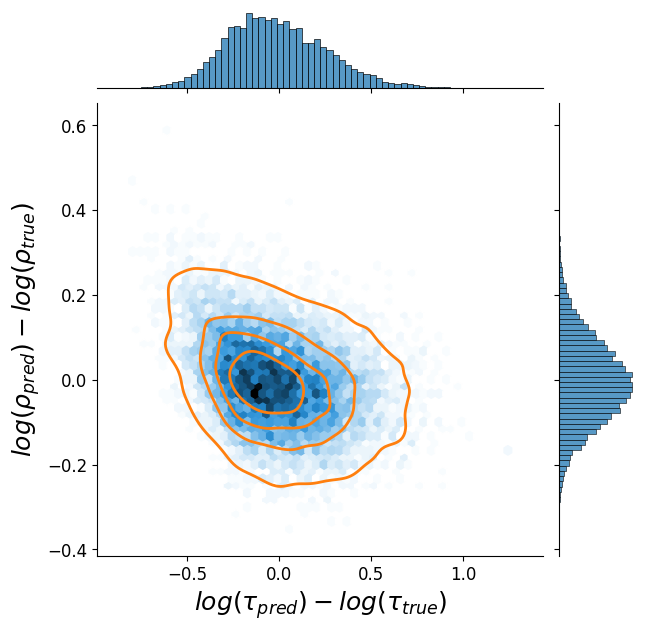

In [ ]:
g = sns.jointplot(x=errors[:,0], y=errors[:,1], kind="hex",color='C0')
g.ax_joint.set_xlabel(r'$log(\tau_{pred}) - log(\tau_{true})$',fontsize=FS)
g.ax_joint.set_ylabel(r'$log(\rho_{pred}) - log(\rho_{true})$',fontsize=FS)
g.ax_joint.tick_params(axis='both', which='major', labelsize=12)


xlim = g.ax_joint.get_xlim()
ylim = g.ax_joint.get_ylim()

#sns.kdeplot(x=errors[0,bounds_mask], y=errors[1,bounds_mask], levels=np.linspace(0.2,0.8,10) ,color="C1", linewidths=2)
sns.kdeplot(x=errors[:,0], y=errors[:,1], levels=5 ,color="C1", linewidths=2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


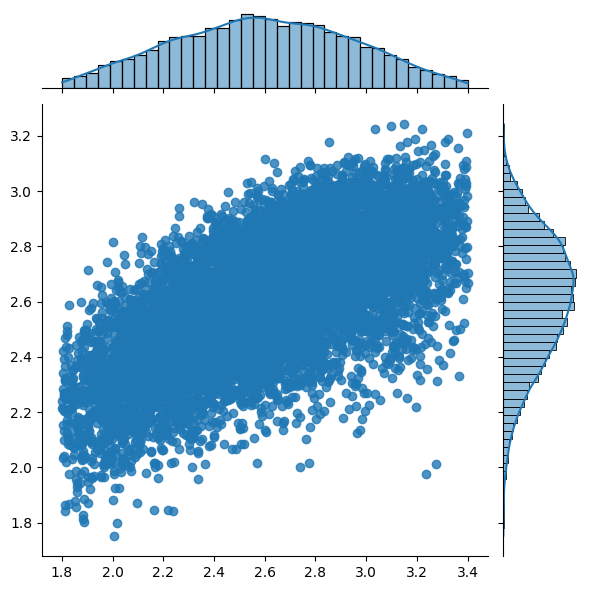

In [ ]:
sns.jointplot(Performance_array[:,0],Performance_array[:,2],kind='reg')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


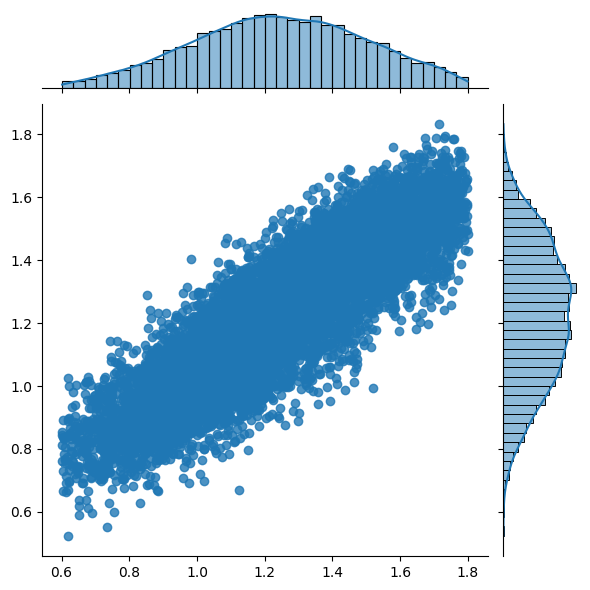

In [ ]:
sns.jointplot(Performance_array[:,1],Performance_array[:,3],kind='reg')